In [18]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import ticker
import numpy as np
from matplotlib import colors


In [19]:
run = "i_lsascent_a"
run_dir = "/glade/scratch/sturbeville/DPSCREAM_simulations/"
file = run_dir + "scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run,run)
qsmall=1e-8

In [20]:
plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other

In [21]:
# vars of interest
# AREI, AWNI, P3_mtend_CLDICE, P3_mtend_NUMICE, P3_ni_nucleat_tend, 
# P3_qc2qi_hetero_frz_tend, P3_sed_CLDICE, P3_qidep
# IWC, CLDICE
# ds = xr.open_dataset(file)
# print(str((ds.time[-1]-ds.time[0]).values/1e9/3600/24).split(" ")[0]," days")
# ds = ds.isel(time=slice(-(60*4)-1, -1))

In [22]:
# # numice_over_awni = ds.NUMICE/ds.AWNI
# # plt.scatter(ds.NUMICE.isel(lev=65), ds.AWNI.isel(lev=65))
# # plt.show()
# plt.scatter(ds.AWNI.isel(lev=65), ds.CLDICE.isel(lev=65))
# plt.xlabel("AWNI (1/m3)")
# plt.ylabel("QI (kg/kg)")
# plt.show()
# plt.scatter(ds.NUMICE.isel(lev=65), ds.CLDICE.isel(lev=65))
# plt.xlabel("NUMICE (1/KG)")
# plt.ylabel("QI (kg/kg)")
# plt.show()


In [23]:
def calc_rice(qi, ni):
    rho = 920 # kg/m3
    qi = qi # kg/kg
    ni =  ni # 1/kg
    r_ice = np.where((ni>1e-5),(3*qi/(4*np.pi*rho*ni))**(1/3),0)*1e6 # um
    return r_ice

def calc_ni(numice, qv, p, t):
    ni = numice * calc_rho(qv,p,t)  # 1/kg * kg/m3 = 1/m3
    return ni

def omega2w(omega, qv, p, t):
    g = 9.8
    w = -omega/(calc_rho(qv,p,t)*g)
    return w


def calc_rhice(ds, varQ="Q", varT="T", z_units="hPa"):
    """ input: xarray with variables Q and T
        output: xarray of rh wrt ice
    """
    e_si = np.exp(9.550426 - 5723.265/ds[varT] \
                  + 3.53068*np.log(ds[varT]) - 0.00728332*ds[varT])
    if z_units=="hPa":
        z = ds.lev*100
    else:
        z=ds.lev
    w_si = (0.622 * e_si) / (z - e_si)
    w_i  = ds[varQ] / (1 - ds[varQ])
    rh_ice = w_i/w_si * 100
    return rh_ice

def calc_rho(qv, p, t):
    """calculates density of air in kg/m3 for given input"""
    R =  287 # (Gas constant of air) J/(kg*K)
    Tv = (1 + 0.61*qv) * t # K
    rho = p / (R*Tv) # kg/m3
    return rho

In [24]:
# rice = calc_rice(ds.CLDICE, ds.NUMICE)
# rice = xr.DataArray(rice, dims=ds.Q.dims, coords=ds.Q.coords,
#             attrs={"long_name":"Mean ice mass radius from eq","units":"um"})
# rice.plot.hist()
# ds = ds.assign({"RICE":rice})
# del rice

# rhi = calc_rhice(ds)
# rhi = rhi.assign_attrs({"long_name":"RH wrt ice", "units":"percent"})
# ds = ds.assign({"RHICE":rhi})
# rhi.plot.hist()
# plt.show()
# del rhi

In [50]:
# ni = calc_ni(1, ds.Q[30,65,45], (ds.lev*100)[65], ds['T'][30,65,45])
# ni

plt_1dhists  = False  # RICE or NI; obs, sim1, sim2 (1D histogram)
plt_2dobs    = False  # RICE vs NI; obs
plt_vstemp   = False  # IWC/NI/RICE vs temp; sim1
plt_2dhists  = False  # RICE vs NI; sim1, sim2
plt_2ddiffs  = True   # RICE vs NI; sim1, sim2, sim1-sim2 
plt_2drhice  = False  # RHice vs NI; all
plt_2dobsvmod= False  # RICE vs NI: obs, sim1, sim2 
plt_icncvsw  = False  # ICNC vs W; sim1

runs = ['h_2xsed_all','g_2xsed']
run_names = ['2x sed (all)', '2x sed (small)']

In [51]:
######################
# histogram of icnc
######################
if plt_1dhists:
    qsmall=1e-8 #kg/kg
    # ybins=np.logspace(-5,2,35)
    ybins = np.arange(0,120,3)
    ybins_mid = (ybins[1:]+ybins[:-1])/2
    hist_obs = None
    plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
    fig, ax = plt.subplots(1, 3, figsize=(18,6), constrained_layout=True, 
                           sharex=True, sharey=True)
    for i in range(len(run_names)+1):
        print(i, end="... ")
        if i>0:
            file = run_dir + "scream_dp_RCE_SMALL_3km_"+runs[i-1]+\
                    "/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i-1])
            ds = xr.open_dataset(file)
            # y_array = calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"]).values.flatten()/1e6 # cm-3
            y_array = calc_rice(ds.CLDICE, ds.NUMICE) # microns
            y_array = np.where((ds["T"]<233.15)&(ds.CLDICE>qsmall)&(y_array>1), y_array, np.nan).flatten() # convert to cm-3
            ax[i].set(xlabel="Rice ($\mu$m)", title=run_names[i-1])
        else:
            file = '/glade/work/sturbeville/obs/ATTREX_POSIDON_CONTRAST/processed/'+\
                'ATT_POS_CONT_microguideII_icnc_rei_runningmean18x.nc'
            ds = xr.open_dataset(file)
            # y_array = ds['ice number concentration']
            y_array = ds['ice mass radius']
            ax[i].set(xlabel="Rice ($\mu$m)", title="OBS")
        y_array = y_array[~np.isnan(y_array)]
        n = len(y_array)
        print(n,"total", end="...")
        hist = np.histogram(y_array, bins=ybins)[0]
        print("plotting... ", end="")
        if i==0:
            hist_obs = hist/n*100
        ax[i].step(ybins_mid, (hist_obs).T, where='mid', color='k')
        ax[i].bar(ybins_mid, (hist/n*100).T,
                  align='center', width=abs(ybins[1:]-ybins[:-1]))
        # ax[i].set(xscale="log", xlabel="ICNC (cm-3)", title=run_names[i])
        
        print("done")
    ax[0].set_ylabel("")
    # plt.savefig("plots/micro_hist_run_NI_obs-{}-{}.png".format(runs[0],runs[1]), dpi=120)
    plt.savefig("plots/micro_hist_run_RICE_obs-{}-{}.png".format(runs[0],runs[1]), dpi=120)
    plt.show()
    #############################################################
    #############################################################


In [52]:
if plt_1dhists or plt_2dobs or plt_2dobsvmod or plt_2drhice: 
    file = '/glade/campaign/univ/uwas0108/blazg/obs_data/cirrus-guideII-database/processed/'+\
                        'ATT_POS_CONT_microguideII_iwc_vs_icnc_Tless-40_runningmean18x.nc'
    ds = xr.open_dataset(file)
    ds

In [53]:
if plt_2dobsvmod:
    fig, ax = plt.subplots(1, 3, figsize=(16,5), sharey=True, sharex=True,
                           constrained_layout=True)
    run_names = ['Obs','Standard','New Frz']
    runs = [None,'ck','ch']
    qsmall=1e-7
    for i in range(3):
        print(i,runs[i],run_names[i],end="...")
        if i==0:
            # file = '/glade/work/sturbeville/obs/ATTREX_POSIDON_CONTRAST/processed/'+\
            #         'ATT_POS_CONT_microguideII_icnc_rei_runningmean18x.nc'
            file = '/glade/campaign/univ/uwas0108/blazg/obs_data/cirrus-guideII-database/processed/'+\
                    'ATT_POS_CONT_microguideII_iwc_vs_icnc_Tless-40_runningmean18x.nc'
            ds = xr.open_dataset(file)
            rice = ds['ice radius']
            # rice = rice.where(rice>0).values
            icnc = ds['ice number concentration']
            # icnc = icnc.where(rice>0).values
            print(np.nanmean(rice), np.nanmean(icnc), end="...")
            hist = ds['binned in-cloud ice crystal radius'].T
            hist = np.where(hist>1, hist, np.nan)
            tot=np.nansum(hist)
            cf = ax[i].pcolormesh(rice, icnc, 100*(hist/tot).T, cmap="magma_r", 
                                  shading="auto", vmax=0.5
                                 )
        else:
            file = run_dir + "scream_dp_RCE_SMALL_3km_"+runs[i]+\
            "/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
            ds = xr.open_dataset(file)
            rice = calc_rice(ds.CLDICE, ds.NUMICE).flatten()
            icnc = calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
            icnc = icnc.where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 #. # convert to cm-3
            print(rice.shape, icnc.shape, end="...")
            rice = rice[~np.isnan(icnc)]
            icnc = icnc[~np.isnan(icnc)]
            print(np.nanmean(rice), np.nanmean(icnc), end="...")
            tot = len(icnc)
            xbins = np.arange(0,141,2)
            ybins = np.logspace(-5,2,71) 
            
            hist = stats.binned_statistic_2d(rice, icnc, None, statistic='count', bins=[xbins,ybins])[0]
            hist = np.where(hist>0, hist, np.nan)
        
            cf = ax[i].pcolormesh(xbins, ybins, 100*(hist/tot).T, cmap="magma_r", 
                                  shading="auto", vmax=0.5
                                 )
        ax[i].set(yscale="log", xlabel="Mean ice mass radius ($\mu$m)", 
                  title=run_names[i], 
                  xlim=[0,100], ylim=[1e-4,10])
        print("done",i+1,"out of 3!")
    ax[0].set(ylabel="ICNC (#/cm$^3$)")
    fig.colorbar(cf, ax=ax[2], label="%", location="right", shrink=1.)    
    savename = "plots/micro_hist_run_RICE-ICNC_obs-{}-{}_forCCIP_1e-4gm-3.png".format(runs[1],runs[2])
    print("saving to",savename)
    plt.savefig(savename, dpi=120)
    plt.show()

In [54]:
###############################
### obs
##############################

if plt_2dobs:
    # file = '/glade/work/sturbeville/obs/ATTREX_POSIDON_CONTRAST/processed/'+\
    #             'ATT_POS_CONT_microguideII_icnc_rei_runningmean18x.nc'
    file = '/glade/campaign/univ/uwas0108/blazg/obs_data/cirrus-guideII-database/processed/'+\
                    'ATT_POS_CONT_microguideII_iwc_vs_icnc_Tless-40_runningmean18x.nc'
    ds = xr.open_dataset(file)
    rice = ds['ice radius']
    # rice = rice.where(rice>0).values
    icnc = ds['ice number concentration']
    # icnc = icnc.where(icnc>0).values
    # print(rice.shape, icnc.shape)
    # rice = rice[~np.isnan(icnc)]
    # icnc = icnc[~np.isnan(icnc)]
    # print(np.nanmean(rice), np.nanmean(icnc))
    # tot = len(icnc)
    # xbins=np.linspace(0,120,35)
    # ybins=10**np.linspace(-5,2,30)
    # xmids = (xbins[1:]+xbins[:-1])/2
    # ymids = (ybins[1:]+ybins[:-1])/2
    # hist = stats.binned_statistic_2d(rice, icnc, None, statistic='count', bins=[xbins,ybins])[0]
    # hist = np.where(hist>0, hist, np.nan)
    # cf100 = plt.contour(xmids, ymids, hist.T, levels=[100])
    xbins = rice
    ybins = icnc
    hist = ds['binned in-cloud ice crystal radius'].T
    hist = np.where(hist>1, hist, np.nan)
    tot = np.nansum(hist)
    cf = plt.pcolormesh(xbins, ybins, 100*(hist/tot).T, cmap="magma_r", 
                              shading="auto", vmax=0.5
                            # locator=ticker.LogLocator(), 
                            # vmin=0, vmax=0.1)
                             )
    plt.yscale("log")
    plt.ylabel("ICNC (cm-3)")
    plt.xlabel("Rice ($\mu$m)")
    plt.colorbar(cf)
    plt.show()  

In [55]:
if plt_vstemp:
    # # # histograms with temperature
    # var_names = ["CLDICE","AWNI","AREI"] # RICE or AREI
    var_names = ["CLDICE","NI","RICE"]
    yi = [np.logspace(-3,3,20), np.logspace(-4,3,20), np.logspace(0,4,40)] 
    xi = np.arange(180,252,2)
    qsmall = 1e-9
    rsmall = 1.5/1e6 # micron

    fig, ax = plt.subplots(len(var_names),1, figsize=(5,3*len(var_names)), constrained_layout=True)
    for i in range(len(var_names)):
        temp_array = ds["T"].values.flatten()
        var_array = ds[var_names[i]].where(ds.CLDICE>qsmall).where(ds[var_names[i]]>0)
        if var_names[i]=="AWNI" or var_names[i]=="NI":
            var_array = var_array/1e6
        elif var_names[i]=="AREI" or var_names[i]=="RICE":
            var_array = var_array.where(ds.AREI>rsmall)
        elif var_names[i]=="CLDICE":
            var_array = var_array*1e6 #g/kg
        var_array = var_array.values.flatten()
        temp_array= temp_array[~np.isnan(var_array)]
        var_array = var_array[~np.isnan(var_array)]
        tot = len(var_array)
        hist, xbins, ybins, _ = stats.binned_statistic_2d(temp_array, var_array, None, 
                                                          statistic="count", bins=[xi, yi[i]])
        xbins = (xbins[1:]+xbins[:-1])/2
        ybins = (ybins[1:]+ybins[:-1])/2
        cf = ax[i].pcolormesh(xbins, ybins, 100*(hist/tot).T, cmap="magma_r", 
                              shading="auto", vmax=2
                            # locator=ticker.LogLocator(), 
                            # vmin=0, vmax=0.1)
                             )

        ax[i].set_ylabel(var_names[i])
        if var_names[i]=="AWNI" or var_names[i]=="NI":
            ax[i].set_title(ds[var_names[i]].long_name+"\n(c"+ds[var_names[i]].units+")")
        elif var_names[i]=="CLDICE":
            ax[i].set_title(ds[var_names[i]].long_name+"\n(ppmv)")
        else:
            ax[i].set_title(ds[var_names[i]].long_name+"\n("+ds[var_names[i]].units+")")
        ax[i].set_yscale("log")
        ax[i].set_xlim([185,250])
        ax[i].grid(True)
        ax[i].set_axisbelow(True)
        ax[i].set_xlabel("Temperature (degC)")
    fig.colorbar(cf, ax=ax, label="count", location="bottom")    
    fig.suptitle("RUN "+run.upper()+" last {} days".format(str((ds.time[-1]-ds.time[0]).values/1e9/3600/24).split(" ")[0]))
    plt.savefig("plots/micro_hist_run_{}-{}-{}_{}.png".format(var_names[0],var_names[1], var_names[2], run))
    plt.show()

In [56]:
if plt_2dhists:
    ############################################################
    # histograms with var1 and var2
    ############################################################
    fig, ax = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
    runs=['g_halfsed','g_2xsed']
    var_names = ["RICE","NI"]
    print("plotting 2d joint histogram of {} and {}".format(var_names[0],var_names[1]))
    for i in range(len(runs)):
        file = run_dir + "scream_dp_RCE_SMALL_3km_"+runs[i]+\
            "/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
        ds = xr.open_dataset(file)
        if var_names[i]=="RICE":
            rice = calc_rice(ds.CLDICE, ds.NUMICE)
        else:
            print("... using AREI model output (ice eff. rad.)")
            rice = ds.AREI.values
        if var_names[i]=="NI":
            ni = calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
        else:
            print("... using AWNI model output (avg. ice concentration, m-3)")
            ni = ds.AWNI
        x_array = rice.flatten() # .where(ds["T"]<243.15).where(ds.CLDICE>qsmall).where(ds.lev<150)
        y_array = ni.where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 #. # convert to cm-3
        x_array = x_array[~np.isnan(y_array)]
        y_array = y_array[~np.isnan(y_array)]
        n = len(x_array)
        xbins=np.linspace(0,100,40)
        ybins=np.logspace(-5,2,40)
        hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                          statistic="count", bins=[xbins,ybins])
        xbins = (xbins[1:]+xbins[:-1])/2
        ybins = (ybins[1:]+ybins[:-1])/2
        hist = np.where(hist>1,hist,np.nan)
        cf = ax[i].pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                              shading='auto',
                              vmin = 1e-9, vmax=0.5 #0.02, 0.3 std
                             )
        ax[i].set_yscale("log")
        ax[i].set_xlabel("Rice ($\mu$m)")
        ax[i].set_ylabel("ICNC (#/cm$^3$)")
        fig.colorbar(cf, ax=ax[i], label="%", location="bottom", shrink=0.8)    
        ax[i].set_title("RUN "+runs[i].upper())
        ax[i].set_xlim([0,100])
        ax[i].set_ylim([5e-5,10])
        savename = "plots/micro_hist_run_{}-{}_{}-{}.png".format(var_names[0],var_names[1],runs[0],runs[1])
    print("saving to",savename)
    plt.savefig(savename, dpi=120)
    plt.show()
    ############################################################

0... 5115912 total...5075426.0 counts...plotting... done
1... 8367236 total...8225715.0 counts...plotting... done
2... plotting... done


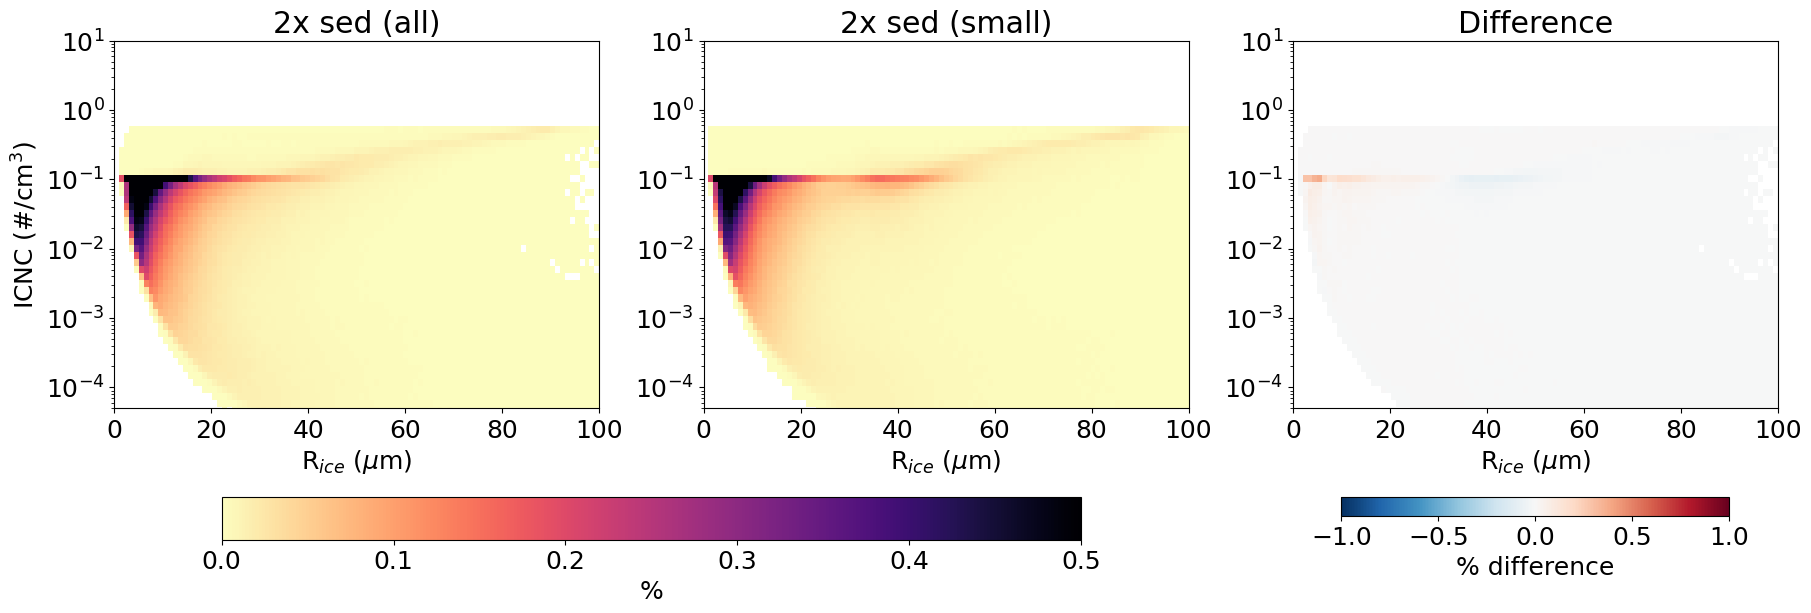

In [57]:
####################################################################
# difference plot between two runs                                 #
####################################################################

if plt_2ddiffs:
    # var_names = ["AREI","AWNI"]
    var_names = ["RICE","NI"]
    hists = [None, None]
    qsmall=1e-8 #kg/kg
    run_names.append("Difference")

    plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
    fig, ax = plt.subplots(1, 3, figsize=(18,6), constrained_layout=True)
    for i in range(len(runs)+1):
        print(i, end="... ")
        if i<2:
            file = run_dir + "scream_dp_RCE_SMALL_3km_"+runs[i]+\
                    "/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
            ds = xr.open_dataset(file)
            if var_names[0]=="RICE":
                x_array = calc_rice(ds.CLDICE, ds.NUMICE).flatten()
            else:
                x_array = ds[var_names[0]].values.flatten()
            if var_names[1]=="NI":
                y_array = calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
                y_array = y_array.where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 #. # convert to cm-3
            else: 
                y_array = ds[var_names[1]].where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 #. # convert to cm-3
            x_array = x_array[~np.isnan(y_array)]
            y_array = y_array[~np.isnan(y_array)]
            n = len(x_array)
            print(n,"total", end="...")
        xbins=np.linspace(0,100,100)
        ybins=np.logspace(-5,2,70)

        if i<2:
            hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                          statistic="count", bins=[xbins,ybins])
            hist = np.where(hist>0,hist,np.nan)
            print(np.nansum(hist),"counts...",end="")
        xbins = (xbins[1:]+xbins[:-1])/2
        ybins = (ybins[1:]+ybins[:-1])/2
        print("plotting... ", end="")
        if i<2:
            hists[i] = hist/n
            cf = ax[i].pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                                  shading='auto',
                                  vmin = 0, vmax=0.5 #0.02, 0.3 std
                                 )
        else:
            cfd = ax[i].pcolormesh(xbins, ybins, ((hists[0]-hists[1])*100).T,  
                                  shading='auto',
                                  cmap="RdBu_r",
                                   norm=colors.Normalize(vmin=-1, vmax=1) #0.02, 0.3 std
                                 )
        ax[i].set(yscale="log", xlabel="R$_{ice}$ ($\mu$m)", title=run_names[i], xlim=[0,100],ylim=[5e-5,10])
        print("done")
    ax[0].set_ylabel("ICNC (#/cm$^3$)")
    fig.colorbar(cf, ax=ax[:2], label="%", location="bottom", shrink=0.8)
    fig.colorbar(cfd, ax=ax[2], label="% difference", location="bottom", shrink=0.8)
    plt.savefig("plots/micro_hist_run_{}-{}_{}-{}-diff.png".format(var_names[0],var_names[1],runs[0],runs[1]), dpi=120)
    run_names[:2]
    plt.show()
    ##############################################################
    ##############################################################

In [49]:

run_names

['2x dep (all)', '2x dep (small)', 'Difference']

In [23]:
if plt_2drhice:
    var_names = ["RHICE","NI"]
    fig, ax = plt.subplots(1, 1, figsize=(5,4), constrained_layout=True)
    x_array = ds[var_names[0]].where(ds["T"]<233.15).values.flatten()
    y_array = ds[var_names[1]].where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 # convert to cm-3
    x_array = x_array[~np.isnan(y_array)]
    y_array = y_array[~np.isnan(y_array)]
    xbins=np.linspace(np.min(x_array),np.max(x_array),50)
    ybins=np.logspace(-5,1,50)
    n = len(x_array)

    hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                      statistic="count", bins=[xbins,ybins])
    xbins = (xbins[1:]+xbins[:-1])/2
    ybins = (ybins[1:]+ybins[:-1])/2
    cf = ax.pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                       shading="auto", vmax=0.4
                        # locator=ticker.LogLocator(), 
                        # levels=np.logspace(0,6,7)
                    )
    ax.set_yscale("log")
    ax.set_xlabel("RH wrt ice (percent)")
    ax.set_ylabel(ds[var_names[1]].long_name+" (c"+ds[var_names[1]].units+")")
    ax.grid(True)
    ax.set_axisbelow(True)
    fig.colorbar(cf, ax=ax, label="%", location="right", shrink=1)    
    ax.set_title("RUN "+run.upper()+" where T$<-40^\circ$C and $qi>{}$".format(qsmall))
    ax.set_xlim([50,150])
    ax.set_ylim([5e-5,10])
    plt.savefig("plots/micro_hist_run_{}-{}_{}.png".format(var_names[0],var_names[1], run), dpi=120)
    plt.show()

In [22]:
####################################################################
# difference plot between two runs                                 #
####################################################################

if plt_2drhice:
    runs = ['ck','ch']
    run_names = ['Standard', 'New Freezing', 'Difference']
    var_names = ["T","RHI"]
    hists = [None, None]
    qsmall=1e-8 #kg/kg
    xbins=np.linspace(180,250,30)
    ybins=np.linspace(0,251,60)

    plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
    fig, ax = plt.subplots(1, 3, figsize=(18,6), constrained_layout=True)
    for i in range(len(run_names)):
        print(i, end="... ")
        if i<2:
            file = run_dir + "scream_dp_RCE_SMALL_3km_"+runs[i]+\
                    "/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
            ds = xr.open_dataset(file)
            x_array = ds[var_names[0]].values.flatten()
            if var_names[1]=="RHI":
                y_array = calc_rhice(ds).values.flatten()
            else:
                y_array = ds[var_names[1]].where(ds.CLDICE>qsmall).values.flatten()
            x_array = x_array[~np.isnan(y_array)]
            y_array = y_array[~np.isnan(y_array)]
            n = len(x_array)
            print(n,"total", end="...")

        if i<2:
            hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                          statistic="count", bins=[xbins,ybins])
            hist = np.where(hist>0,hist,np.nan)
            print(np.nansum(hist),"counts...",end="")
        xbins = (xbins[1:]+xbins[:-1])/2
        ybins = (ybins[1:]+ybins[:-1])/2
        print("plotting... ", end="")
        if i<2:
            hists[i] = hist/n
            cf = ax[i].pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                                  shading='auto',
                                  vmin = 0, vmax=0.5 #0.02, 0.3 std
                                 )
        else:
            cfd = ax[i].pcolormesh(xbins, ybins, ((hists[0]-hists[1])*100).T,  
                                  shading='auto',
                                  cmap="RdBu_r",
                                   norm=colors.Normalize(vmin=-0.5, vmax=0.5) #0.02, 0.3 std
                                 )
        print("done")
        ax[i].set(xlabel="Temperature (K)", title=run_names[i], xlim=[180,250], ylim=[40,160])
    ax[0].set(ylabel="RH$_{i}$ (%)")
    fig.colorbar(cf, ax=ax[:2], label="%", location="bottom", shrink=0.8)
    fig.colorbar(cfd, ax=ax[2], label="% difference", location="bottom", shrink=0.8)
    plt.savefig("plots/micro_hist_run_{}-{}_{}-{}-diff.png".format(var_names[0],var_names[1],runs[0],runs[1]), dpi=120)
    plt.show()
    ##############################################################
    ##############################################################


In [21]:
####################################################################
# difference plot between two runs                                 #
####################################################################

if plt_2drhice:
    runs = ['ck','ch']
    run_names = ['Standard', 'New Freezing', 'Difference']
    var_names = ["RHI","NI"]
    hists = [None, None]
    qsmall=1e-8 #kg/kg
    xbins=np.linspace(180,250,30)
    ybins=np.linspace(0,250,60)

    plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
    fig, ax = plt.subplots(1, 3, figsize=(18,6), constrained_layout=True)
    for i in range(len(run_names)):
        print(i, end="... ")
        if i<2:
            file = run_dir + "scream_dp_RCE_SMALL_3km_"+runs[i]+\
                    "/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
            ds = xr.open_dataset(file)
            if var_names[0]=="RHI":
                x_array = calc_rhice(ds).values.flatten()
            else:
                x_array = ds[var_names[0]].where(ds.CLDICE>qsmall).values.flatten()
            if var_names[1]=="NI":
                y_array = calc_rhice(ds).values.flatten()/1e6
            else:
                y_array = ds[var_names[1]].where(ds.CLDICE>qsmall).values.flatten()        
            x_array = x_array[~np.isnan(y_array)]
            y_array = y_array[~np.isnan(y_array)]
            n = len(x_array)
            print(n,"total", end="...")

        if i<2:
            hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                          statistic="count", bins=[xbins,ybins])
            hist = np.where(hist>0,hist,np.nan)
            print(np.nansum(hist),"counts...",end="")
        xbins = (xbins[1:]+xbins[:-1])/2
        ybins = (ybins[1:]+ybins[:-1])/2
        print("plotting... ", end="")
        if i<2:
            hists[i] = hist/n
            cf = ax[i].pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                                  shading='auto',
                                  vmin = 0, vmax=0.5 #0.02, 0.3 std
                                 )
        else:
            cfd = ax[i].pcolormesh(xbins, ybins, ((hists[0]-hists[1])*100).T,  
                                  shading='auto',
                                  cmap="RdBu_r",
                                   norm=colors.Normalize(vmin=-0.5, vmax=0.5) #0.02, 0.3 std
                                 )
        print("done")
        ax[i].set(xlabel="RHi (%)", title=run_names[i], xlim=[180,250], ylim=[40,160])
    ax[0].set(ylabel="ICNC (cm$^-3$)")
    fig.colorbar(cf, ax=ax[:2], label="%", location="bottom", shrink=0.8)
    fig.colorbar(cfd, ax=ax[2], label="% difference", location="bottom", shrink=0.8)
    plt.savefig("plots/micro_hist_run_{}-{}_{}-{}-diff.png".format(var_names[0],var_names[1],runs[0],runs[1]), dpi=120)
    plt.show()
    ##############################################################
    ##############################################################


In [ ]:
##############################################
# ICNC vs w
##############################################

if plt_icncvsw:
    ds = xr.open_dataset(file)
    print()
    w = omega2w(ds.OMEGA, ds.Q, ds.lev, ds.T)